# Saving dataset as hdf5

* If svaing numpy array image it doubles the size.

* This blog explains how to save in smaller size as python io 
https://blade6570.github.io/soumyatripathy/hdf5_blog.html

In [13]:
import pandas as pd
import numpy as np
import os
from PIL import Image
from tqdm import tqdm

In [2]:
import h5py
import io

## Reading the filenames

going through the folders and reading corresponding extrinsic files

In [3]:
files_directory = '/home/deebuls/Documents/phd/dataset/virtual_kitti'
  
scene_folder_name = ['Scene01','Scene02','Scene06','Scene18','Scene20']
scenario_folder_name = ['15-deg-left','15-deg-right','30-deg-left',
                         '30-deg-right','clone','fog','morning',
                         'overcast','rain','sunset']
data_folder_name = ['classSegmentation','rgb','depth']
file_prefix_name = ['classgt', 'rgb', 'depth']
file_format_name = ['png', 'jpg', 'png']
output_name = ['mask', 'image', 'depth']
camera_folder_name = ['Camera_0', 'Camera_1']
data_column_names=['scene', 'scenario', 'camera_number', 'frame_number']
extrinsic_row_names = ['r1,1', 'r1,2', 'r1,3', 't1', 'r2,1', 'r2,2',
'r2,3', 't2', 'r3,1', 'r3,2', 'r3,3', 't3', '0', '0.1', '0.2', '1'] 

In [4]:
%%time
filenames = []
for scene in scene_folder_name:
    for scenario in scenario_folder_name:
        extrinsic = pd.read_csv(os.path.join(files_directory, scene, scenario,'extrinsic.txt'), delimiter=' ')
        for camera in camera_folder_name:
            single_filenames = os.listdir(os.path.join(files_directory, scene, scenario, 'frames', 'rgb', camera))
            single_filenames.sort()
            for f in single_filenames:
                #Splitting filename rgb_0000.jpg first replacing '.' with '_'
                _, frame_number, _ = f.replace('.','_').split('_') 
                _, camera_number = camera.split('_')
                #Loc is a slow query 
                x = extrinsic.loc[(extrinsic['frame'] == int(frame_number)) & \
                                  (extrinsic['cameraID'] == int(camera_number)), 
                                  extrinsic_row_names].values.flatten().tolist()
                filenames.append([scene, scenario, camera, frame_number, x])
                
filenames = pd.DataFrame(filenames, columns=['scene', 'scenario', 'camera_number', 'frame_number', 'extrinsic'])

CPU times: user 31.2 s, sys: 77.4 ms, total: 31.2 s
Wall time: 31.3 s


In [5]:
filenames


,scene,scenario,camera_number,frame_number,extrinsic
0,Scene01,15-deg-left,Camera_0,00000,"[-0.008019686, 0.07217909, -0.9973595, 7.49445..."
1,Scene01,15-deg-left,Camera_0,00001,"[-0.007779241, 0.0730738, -0.9972962, 7.283874..."
2,Scene01,15-deg-left,Camera_0,00002,"[-0.008015394, 0.06971319, -0.9975349, 6.62668..."
3,Scene01,15-deg-left,Camera_0,00003,"[-0.008151174, 0.06922305, -0.997568, 6.289214..."
4,Scene01,15-deg-left,Camera_0,00004,"[-0.007937193, 0.06872611, -0.9976041, 5.91949..."
...,...,...,...,...,...
42515,Scene20,sunset,Camera_1,00832,"[-0.7014188, -0.01358945, -0.7126198, -111.951..."
42516,Scene20,sunset,Camera_1,00833,"[-0.7014475, -0.01355444, -0.7125923, -111.909..."
42517,Scene20,sunset,Camera_1,00834,"[-0.7014322, -0.01353448, -0.712608, -111.9159..."
42518,Scene20,sunset,Camera_1,00835,"[-0.7014487, -0.01356346, -0.7125909, -111.904..."


In [6]:
filenames.iloc[0]

scene                                                      Scene01
scenario                                               15-deg-left
camera_number                                             Camera_0
frame_number                                                 00000
extrinsic        [-0.008019686, 0.07217909, -0.9973595, 7.49445...
Name: 0, dtype: object

### Openining  a single file 

In [33]:
scene, scenario, camera, frame_number, x = filenames.iloc[0]
sample = {}
for folder, prefix, file_format, output in zip(data_folder_name, 
                                       file_prefix_name,
                                       file_format_name,
                                       output_name):
    frame_name = prefix+'_'+frame_number+'.'+file_format
    image_path = os.path.join(files_directory, 
                              scene, 
                              scenario, 
                              'frames', 
                              folder, 
                              camera, 
                              frame_name)
    sample[output] = np.array(Image.open(image_path))
           

## Creating h5 files in the output directory

In [21]:
output_files_directory = '/home/deebuls/Documents/phd/dataset/virtual_kitti_h5'
if not os.path.exists(output_files_directory):
    os.makedirs(output_files_directory)


In [23]:
with tqdm(total=len(filenames)) as progress_bar:
    for index, row in filenames.iterrows():    
        data_filename = row['scene']+'_'+row['scenario']+'_'+row['camera_number']+'_'+row['frame_number']+'.h5'
        data_filename = os.path.join(output_files_directory, data_filename)
        sample = {}
        h5f = h5py.File(data_filename, 'w')
        for folder, prefix, file_format, output in zip(data_folder_name, 
                                               file_prefix_name,
                                               file_format_name,
                                               output_name):
            frame_name = prefix+'_'+str(row['frame_number']).zfill(5)+'.'+file_format
            image_path = os.path.join(files_directory, 
                                      row['scene'], 
                                      row['scenario'], 
                                      'frames', 
                                      folder, 
                                      row['camera_number'], 
                                      frame_name)
            with open(image_path, 'rb') as img_f:
                binary_data = img_f.read()      # read the image as python binary
            binary_data_np = np.asarray(binary_data)
            h5f.create_dataset(output, data=binary_data_np)




        h5f.create_dataset('extrinsic', data=np.array(row['extrinsic']).reshape(4,4))
        h5f.close()
        progress_bar.update(1)


100%|████████████████████████████████████████████████████████| 42520/42520 [02:06<00:00, 335.29it/s]


### Saving filenames pandas Dataframe

In [10]:
filenames.to_csv(output_files_directory+'/virtual_kiti_file_naming.csv')

## Reading files

In [24]:
data_filename = '/home/deebuls/Documents/phd/dataset/virtual_kitti_h5/Scene01_15-deg-left_Camera_0_00001.h5'
#Reading image as PIL image format
with h5py.File(data_filename, 'r') as data: 
    images = Image.open(io.BytesIO(np.array(data['image'])))
    maskes = Image.open(io.BytesIO(np.array(data['mask'])))
    transformation_matrices=np.array(data['extrinsic'])



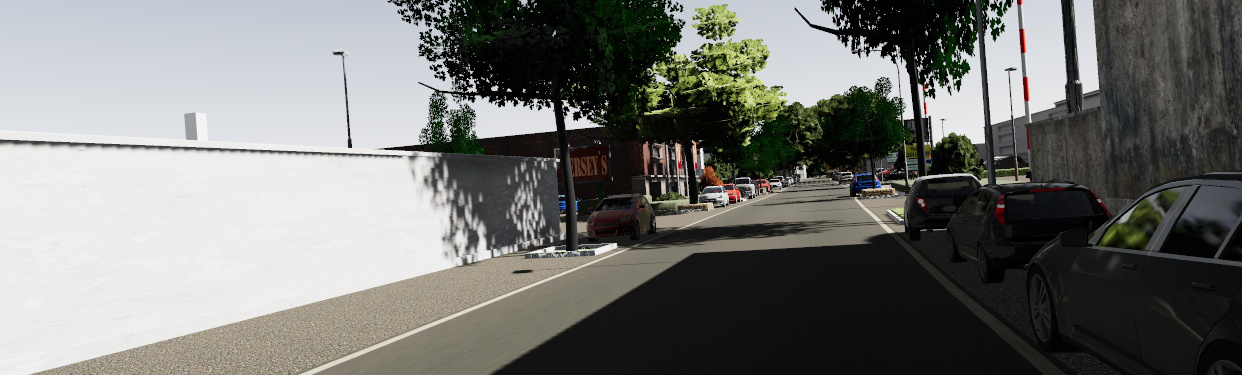

In [25]:
images

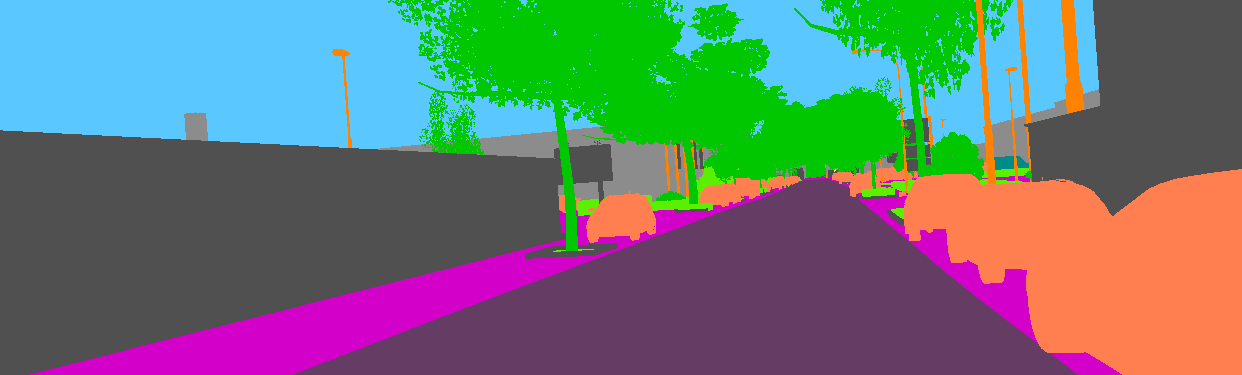

In [26]:
maskes



In [29]:
data_filename = '/home/deebuls/Documents/phd/dataset/virtual_kitti_h5/Scene01_15-deg-left_Camera_0_00002.h5'
#Reading image as PIL image format
with h5py.File(data_filename, 'r') as data: 
    images = Image.open(io.BytesIO(np.array(data['image'])))
    maskes = Image.open(io.BytesIO(np.array(data['mask'])))
    transformation_matrices=np.array(data['extrinsic'])


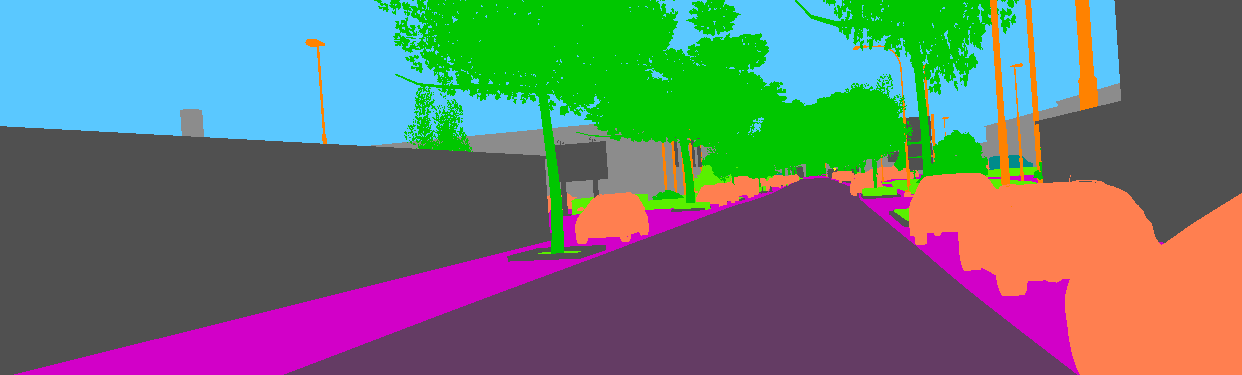

In [30]:
maskes

In [17]:

#Reading image as numpy
with h5py.File(data_filename, 'r') as data: 
    images = np.asarray(Image.open(io.BytesIO(np.array(data['image']))))
    maskes = np.asarray(Image.open(io.BytesIO(np.array(data['mask']))))
    transformation_matrices=np.array(data['extrinsic'])


In [18]:
type(images)

numpy.ndarray

## Reshaping nd saving file in hdf5

In [18]:
output_files_directory = '/home/deebuls/Documents/phd/dataset/virtual_kitti_h5'
if not os.path.exists(output_files_directory):
    os.makedirs(output_files_directory)


In [ ]:
#Resize shape 
(width, height) = (256, 256)

In [21]:
with tqdm(total=len(filenames)) as progress_bar:

    for index, row in filenames.iterrows():    
            data_filename = row['scene']+'_'+row['scenario']+'_'+row['camera_number']+'_'+row['frame_number']+'.h5'
            data_filename = os.path.join(output_files_directory, data_filename)
            sample = {}        
            with h5py.File(data_filename,'w') as h5f:

                for folder, prefix, file_format, output in zip(data_folder_name, 
                                                       file_prefix_name,
                                                       file_format_name,
                                                       output_name):
                    frame_name = prefix+'_'+str(row['frame_number']).zfill(5)+'.'+file_format
                    image_path = os.path.join(files_directory, 
                                              row['scene'], 
                                              row['scenario'], 
                                              'frames', 
                                              folder, 
                                              row['camera_number'], 
                                              frame_name)

                    #with Image.open(image_path) as im:
                    im = Image.open(image_path)
                    # Provide the target width and height of the image

                    im_resized = im.resize((width, height))
                    buf = io.BytesIO()
                    if 'jpg' == file_format:
                        file_format = 'JPEG'
                    im_resized.save(buf, format=file_format)
                    byte_im = buf.getvalue()
                    binary_data_np = np.asarray(byte_im)
                    h5f.create_dataset(output, data=binary_data_np)

                h5f.create_dataset('extrinsic', data=np.array(row['extrinsic']).reshape(4,4))
                h5f.close()
                progress_bar.update(1)


100%|█████████████████████████████████████████████████████████| 42520/42520 [22:26<00:00, 31.58it/s]


In [8]:
%%timeit
#Reading image as PIL image format
with h5py.File(data_filename, 'r') as data: 
    images = np.copy(np.asarray(Image.open(io.BytesIO(np.array(data['image'])))))
    maskes = np.copy(np.asarray(Image.open(io.BytesIO(np.array(data['mask'])))))
    depth = np.copy(np.asarray(Image.open(io.BytesIO(np.array(data['depth'])))))
    transformation_matrices=np.array(data['extrinsic'])



21.1 ms ± 1.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
%%timeit
#Reading image as PIL image format
with h5py.File(data_filename, 'r') as data: 
    images = np.copy(np.asarray(Image.open(io.BytesIO(np.array(data['image'])))))
    maskes = np.copy(np.asarray(Image.open(io.BytesIO(np.array(data['mask'])))))
    depth = np.copy(np.asarray(Image.open(io.BytesIO(np.array(data['depth'])))))
    transformation_matrices=np.array(data['extrinsic'])



3.54 ms ± 625 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
#Reading image as PIL image format
with h5py.File(data_filename, 'r') as data: 
    images = np.copy(np.asarray(Image.open(io.BytesIO(np.array(data['image'])))))
    maskes = np.copy(np.asarray(Image.open(io.BytesIO(np.array(data['mask'])))))
    depth = np.copy(np.asarray(Image.open(io.BytesIO(np.array(data['depth'])))))
    transformation_matrices=np.array(data['extrinsic'])

In [19]:
#Reading image as PIL image format
with h5py.File(data_filename, 'r') as data: 
    images = Image.open(io.BytesIO(np.array(data['image'])))
    maskes = Image.open(io.BytesIO(np.array(data['mask'])))
    depth = Image.open(io.BytesIO(np.array(data['depth'])))
    transformation_matrices=np.array(data['extrinsic'])

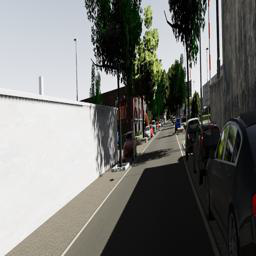

In [20]:
images

## Analysiz filenames for categories 

In [25]:
filenames.scenario.unique()

array(['15-deg-left', '15-deg-right', '30-deg-left', '30-deg-right',
       'clone', 'fog', 'morning', 'overcast', 'rain', 'sunset'],
      dtype=object)

In [10]:
for s in filenames.scenario.unique():
    print (s,filenames[filenames['scenario'].isin([s])].shape[0])

15-deg-left 4252
15-deg-right 4252
30-deg-left 4252
30-deg-right 4252
clone 4252
fog 4252
morning 4252
overcast 4252
rain 4252
sunset 4252


In [12]:
subset =  ['15-deg-left', '15-deg-right', '30-deg-left', '30-deg-right']
filenames[filenames['scenario'].isin(subset)]

,scene,scenario,camera_number,frame_number,extrinsic
0,Scene01,15-deg-left,Camera_0,00000,"[-0.008019686, 0.07217909, -0.9973595, 7.49445..."
1,Scene01,15-deg-left,Camera_0,00001,"[-0.007779241, 0.0730738, -0.9972962, 7.283874..."
2,Scene01,15-deg-left,Camera_0,00002,"[-0.008015394, 0.06971319, -0.9975349, 6.62668..."
3,Scene01,15-deg-left,Camera_0,00003,"[-0.008151174, 0.06922305, -0.997568, 6.289214..."
4,Scene01,15-deg-left,Camera_0,00004,"[-0.007937193, 0.06872611, -0.9976041, 5.91949..."
...,...,...,...,...,...
32471,Scene20,30-deg-right,Camera_1,00832,"[-0.9637563, -0.01358945, -0.2664376, 245.7298..."
32472,Scene20,30-deg-right,Camera_1,00833,"[-0.9637675, -0.01355444, -0.2663991, 245.7696..."
32473,Scene20,30-deg-right,Camera_1,00834,"[-0.9637618, -0.01353448, -0.2664207, 245.7634..."
32474,Scene20,30-deg-right,Camera_1,00835,"[-0.963768, -0.01356346, -0.2663976, 245.7737,..."


In [ ]:
df[df['A'].isin([3, 6])]